# Exploratory Data Analysis - Clickstream Features

This notebook performs exploratory data analysis on the clickstream features data. This data contains user behavioral information that might be predictive of loan default behavior.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier

# Set plot style
sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Loading the Data

In [2]:
# Load clickstream data
clickstream_data_path = '../data/feature_clickstream.csv'
clickstream_df = pd.read_csv(clickstream_data_path)

# Display basic information
print(f"Clickstream data shape: {clickstream_df.shape}")
clickstream_df.head()

Clickstream data shape: (215376, 22)


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,fe_11,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,63,118,80,121,55,193,111,112,-101,83,164,105,-16,-81,-126,114,35,85,-73,76,CUS_0x1037,2023-01-01
1,-108,182,123,4,-56,27,25,-6,284,222,203,190,-14,-96,200,35,130,94,111,75,CUS_0x1069,2023-01-01
2,-13,8,87,166,214,-98,215,152,129,139,14,203,26,86,171,125,-130,354,17,302,CUS_0x114a,2023-01-01
3,-85,45,200,89,128,54,76,51,61,139,6,197,172,96,174,163,37,207,180,118,CUS_0x1184,2023-01-01
4,55,120,226,-86,253,97,107,68,103,126,34,12,76,43,183,159,-26,104,118,184,CUS_0x1297,2023-01-01


## 2. Data Overview and Basic Statistics

In [3]:
# Check data types
clickstream_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215376 entries, 0 to 215375
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   fe_1           215376 non-null  int64 
 1   fe_2           215376 non-null  int64 
 2   fe_3           215376 non-null  int64 
 3   fe_4           215376 non-null  int64 
 4   fe_5           215376 non-null  int64 
 5   fe_6           215376 non-null  int64 
 6   fe_7           215376 non-null  int64 
 7   fe_8           215376 non-null  int64 
 8   fe_9           215376 non-null  int64 
 9   fe_10          215376 non-null  int64 
 10  fe_11          215376 non-null  int64 
 11  fe_12          215376 non-null  int64 
 12  fe_13          215376 non-null  int64 
 13  fe_14          215376 non-null  int64 
 14  fe_15          215376 non-null  int64 
 15  fe_16          215376 non-null  int64 
 16  fe_17          215376 non-null  int64 
 17  fe_18          215376 non-null  int64 
 18  fe_1

In [4]:
# Check basic statistics
clickstream_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fe_1,215376.0,101.414796,99.833594,-378.0,34.0,102.0,169.0,541.0
fe_2,215376.0,103.096195,99.930002,-356.0,36.0,103.0,171.0,560.0
fe_3,215376.0,104.333709,100.599865,-399.0,36.0,104.0,172.0,583.0
fe_4,215376.0,105.648503,100.326065,-307.0,38.0,106.0,173.0,562.0
fe_5,215376.0,106.996676,100.693607,-343.0,39.0,107.0,175.0,570.0
fe_6,215376.0,103.235922,100.270388,-321.0,36.0,103.0,171.0,565.0
fe_7,215376.0,107.070337,100.323265,-368.0,39.0,107.0,174.0,537.0
fe_8,215376.0,110.718724,100.243698,-361.0,43.0,111.0,179.0,573.0
fe_9,215376.0,114.406354,100.186139,-328.0,47.0,115.0,182.0,577.0
fe_10,215376.0,117.775797,100.807686,-317.0,50.0,118.0,186.0,537.0


## 3. Data Quality Check

In [5]:
# Check for missing values
missing_values = clickstream_df.isnull().sum()
missing_percentage = (missing_values / len(clickstream_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage
})

# Display only columns with missing values
missing_df = missing_df.loc[missing_df['Missing Values'] > 0]
if not missing_df.empty:
    print("Columns with missing values:")
    display(missing_df)
else:
    print("No missing values found in the dataset!")

No missing values found in the dataset!


In [6]:
# Check for duplicates
duplicate_rows = clickstream_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


## 4. Feature Analysis

In [7]:
# Convert snapshot_date to datetime
clickstream_df['snapshot_date'] = pd.to_datetime(clickstream_df['snapshot_date'])

# Check date range
print(f"Date range: {clickstream_df['snapshot_date'].min()} to {clickstream_df['snapshot_date'].max()}")

Date range: 2023-01-01 00:00:00 to 2024-12-01 00:00:00


In [8]:
# Count unique customers
unique_customers = clickstream_df['Customer_ID'].nunique()
print(f"Number of unique customers: {unique_customers}")

Number of unique customers: 8974


In [9]:
# Analyze feature columns (fe_1 to fe_20)
feature_cols = [col for col in clickstream_df.columns if col.startswith('fe_')]

# Statistical summary of feature columns
clickstream_df[feature_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
fe_1,215376.0,101.414796,99.833594,-378.0,34.0,102.0,169.0,541.0
fe_2,215376.0,103.096195,99.930002,-356.0,36.0,103.0,171.0,560.0
fe_3,215376.0,104.333709,100.599865,-399.0,36.0,104.0,172.0,583.0
fe_4,215376.0,105.648503,100.326065,-307.0,38.0,106.0,173.0,562.0
fe_5,215376.0,106.996676,100.693607,-343.0,39.0,107.0,175.0,570.0
fe_6,215376.0,103.235922,100.270388,-321.0,36.0,103.0,171.0,565.0
fe_7,215376.0,107.070337,100.323265,-368.0,39.0,107.0,174.0,537.0
fe_8,215376.0,110.718724,100.243698,-361.0,43.0,111.0,179.0,573.0
fe_9,215376.0,114.406354,100.186139,-328.0,47.0,115.0,182.0,577.0
fe_10,215376.0,117.775797,100.807686,-317.0,50.0,118.0,186.0,537.0


## 5. Distribution Analysis

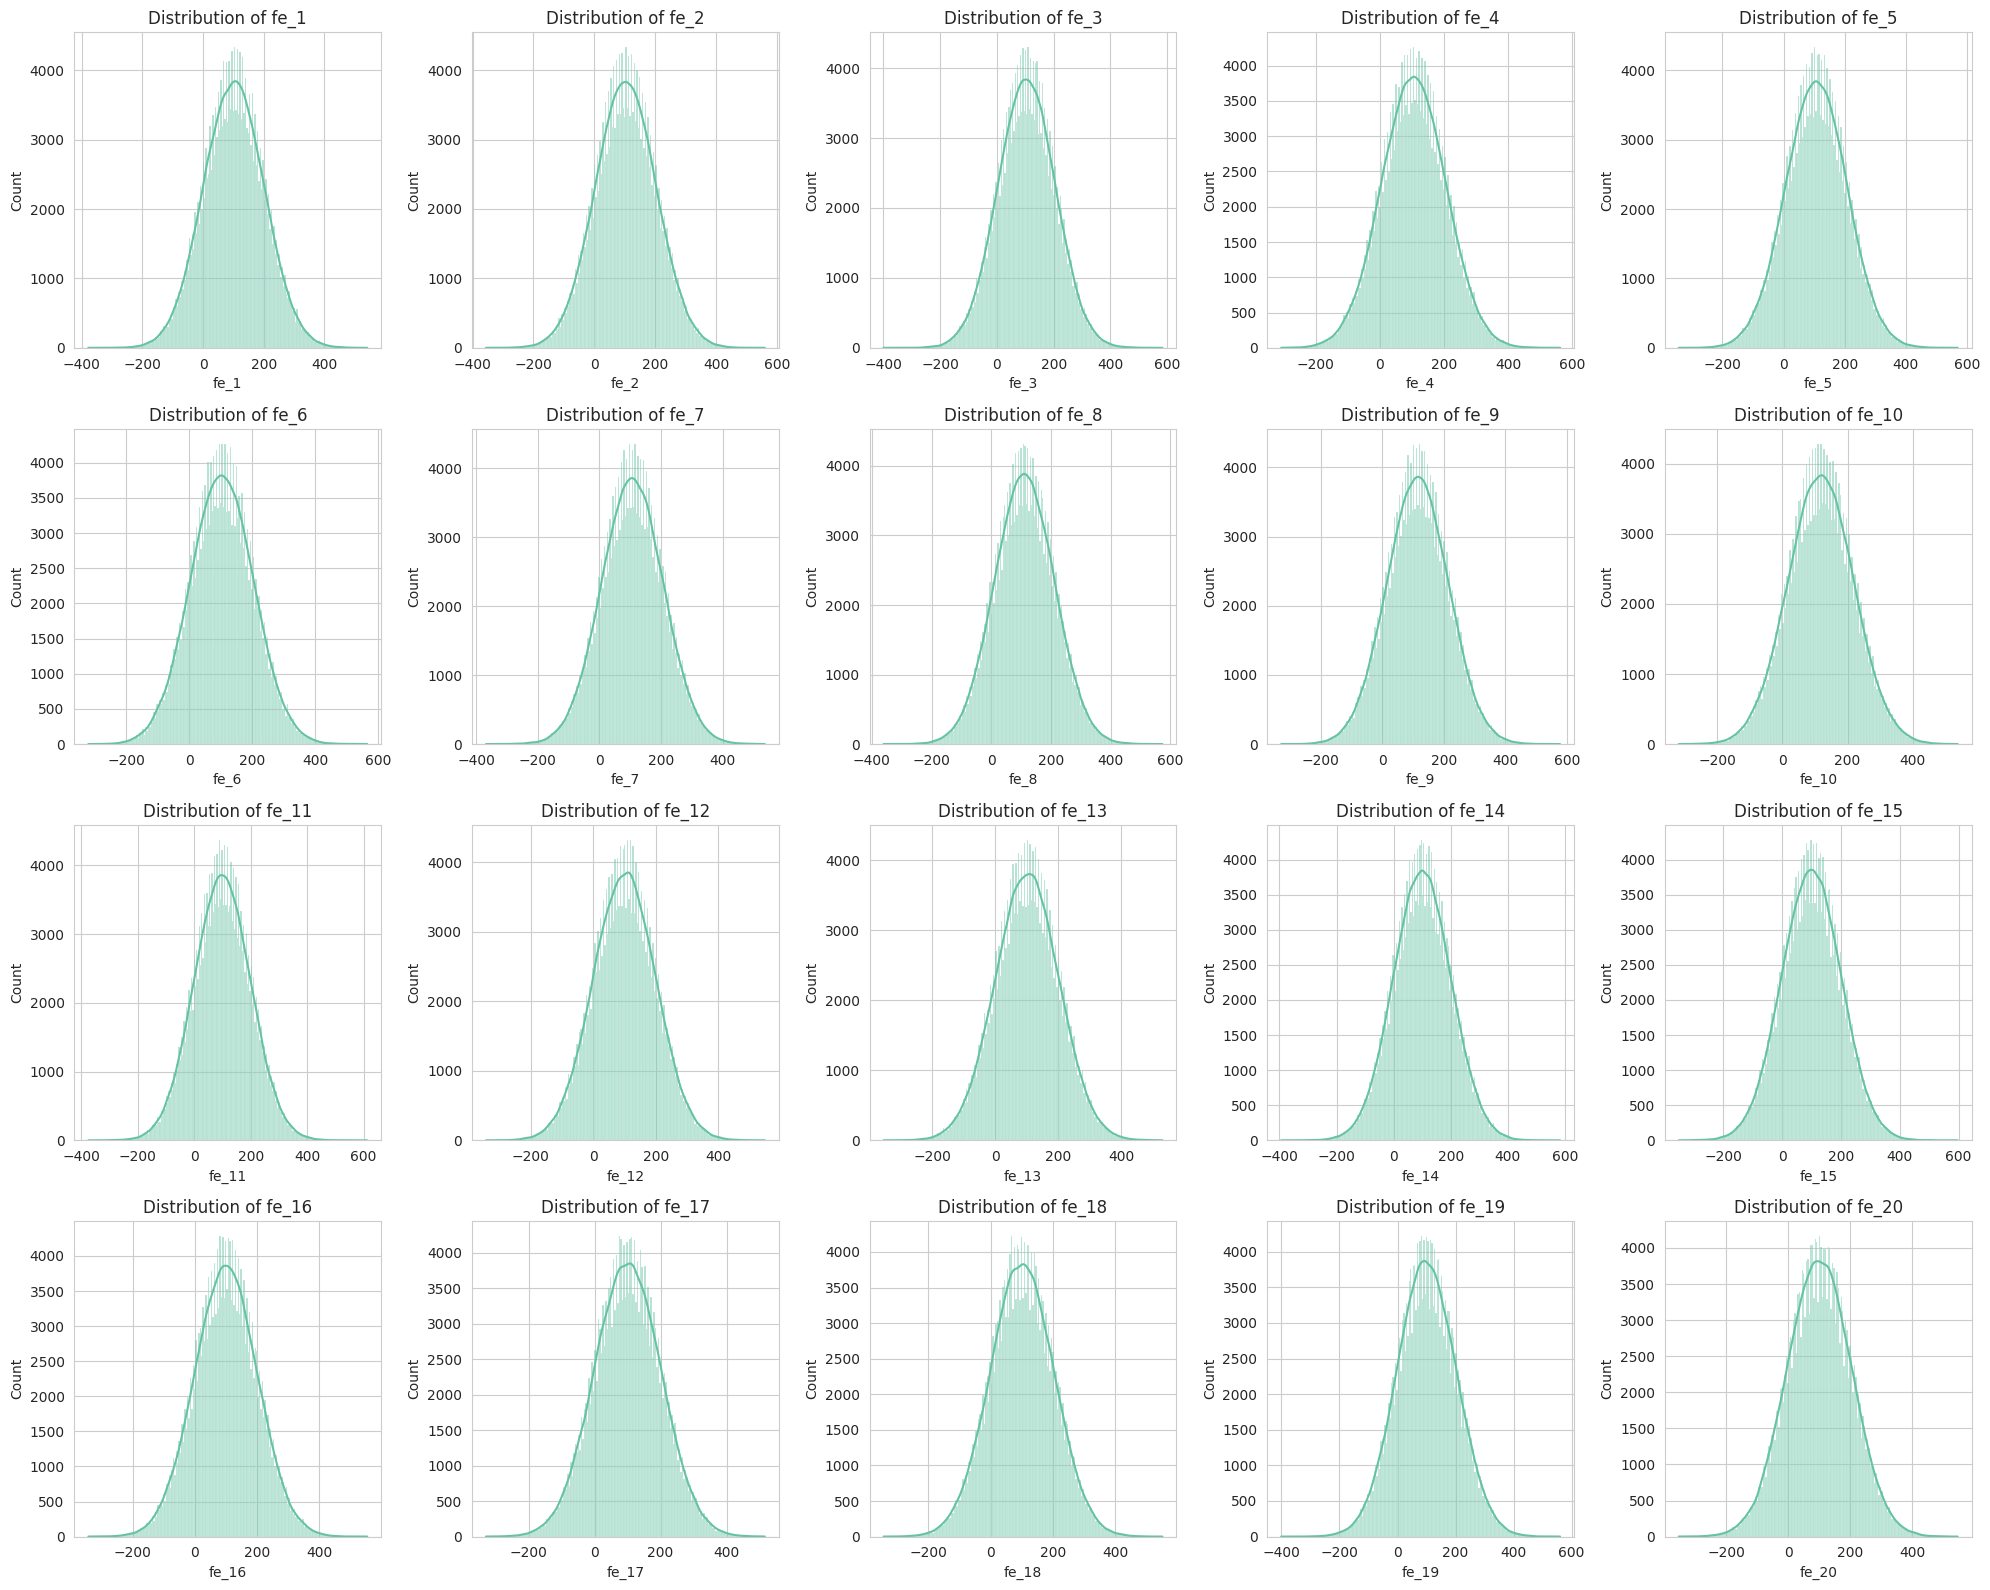

In [10]:
# Plot distribution of each feature
def plot_feature_distributions(df, columns, rows=4, cols=5):
    plt.figure(figsize=(20, 16))
    for i, column in enumerate(columns):
        plt.subplot(rows, cols, i+1)
        sns.histplot(df[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.tight_layout()
    plt.show()

plot_feature_distributions(clickstream_df, feature_cols)

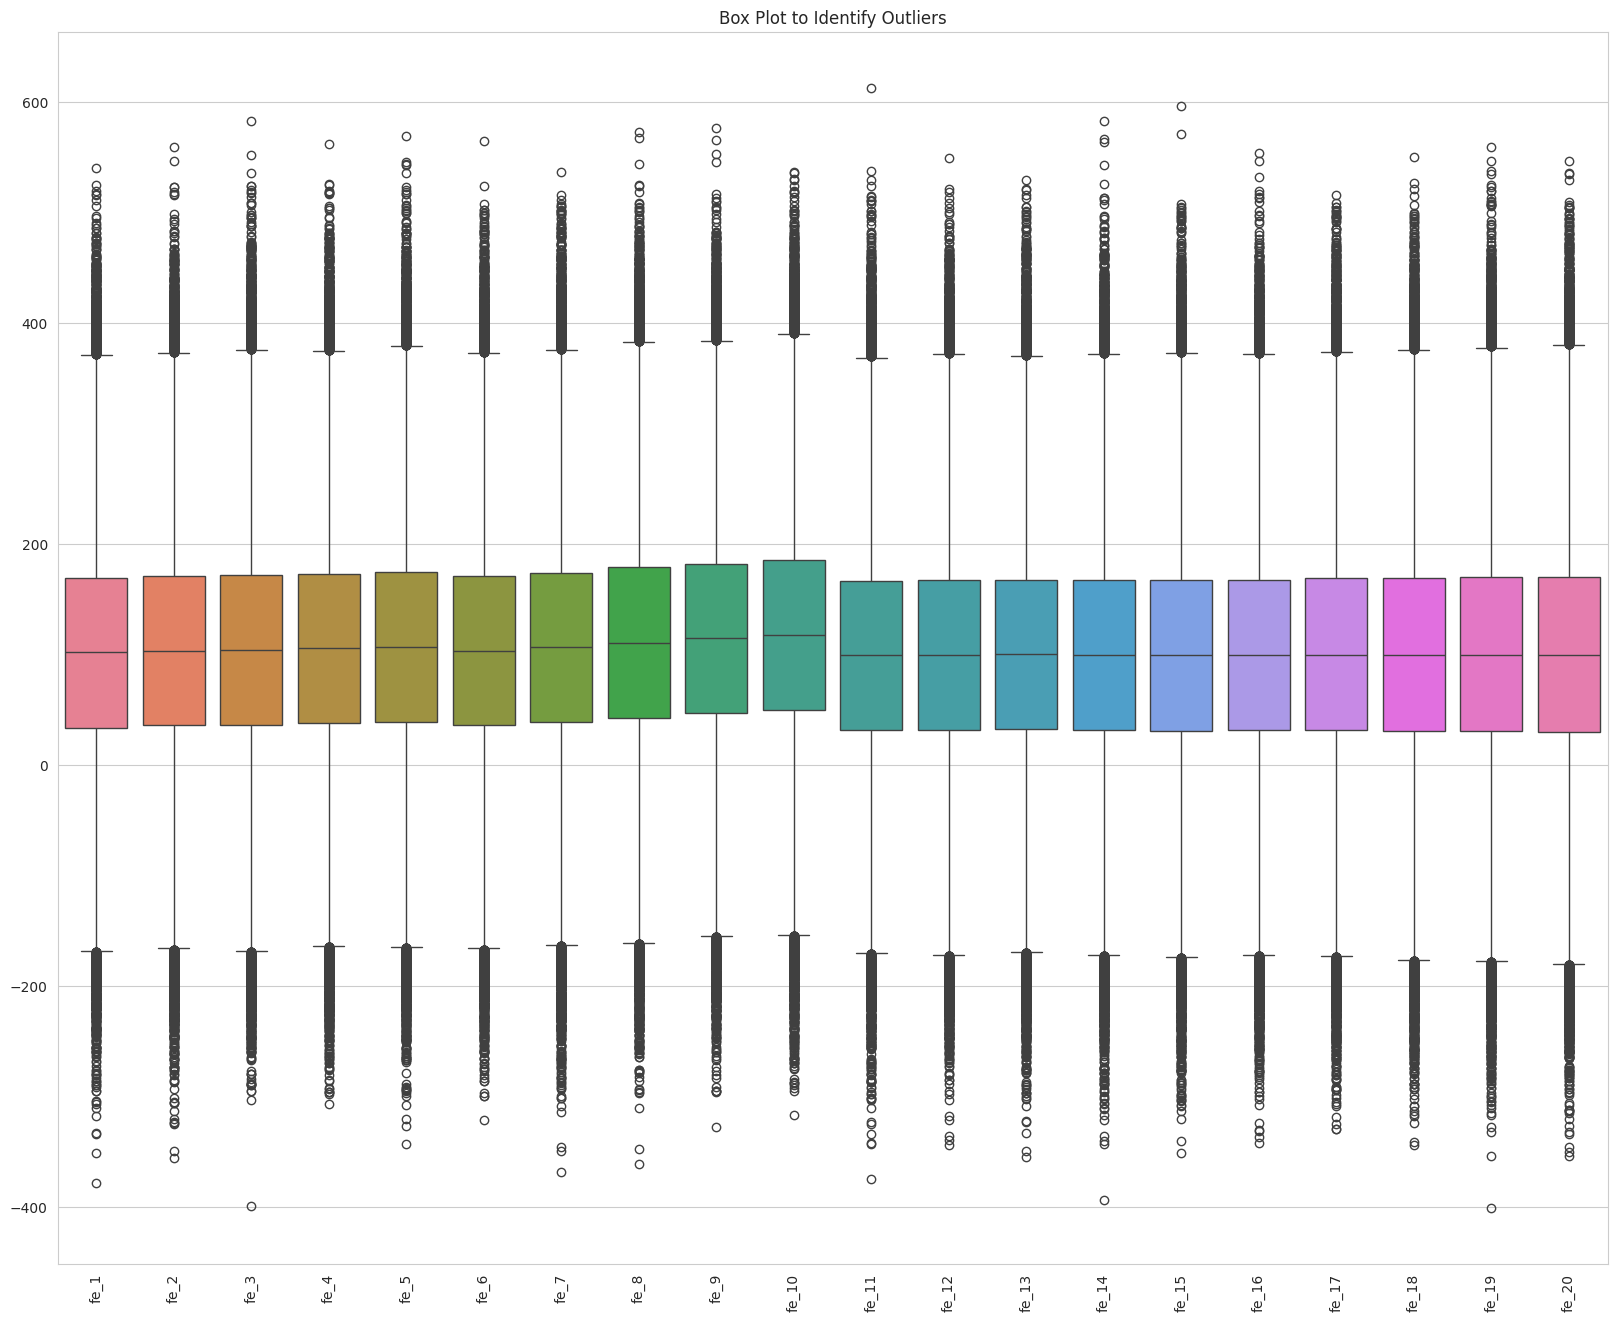

In [11]:
# Check for outliers in features using box plots
plt.figure(figsize=(20, 16))
sns.boxplot(data=clickstream_df[feature_cols])
plt.title('Box Plot to Identify Outliers')
plt.xticks(rotation=90)
plt.show()

## 6. Correlation Analysis

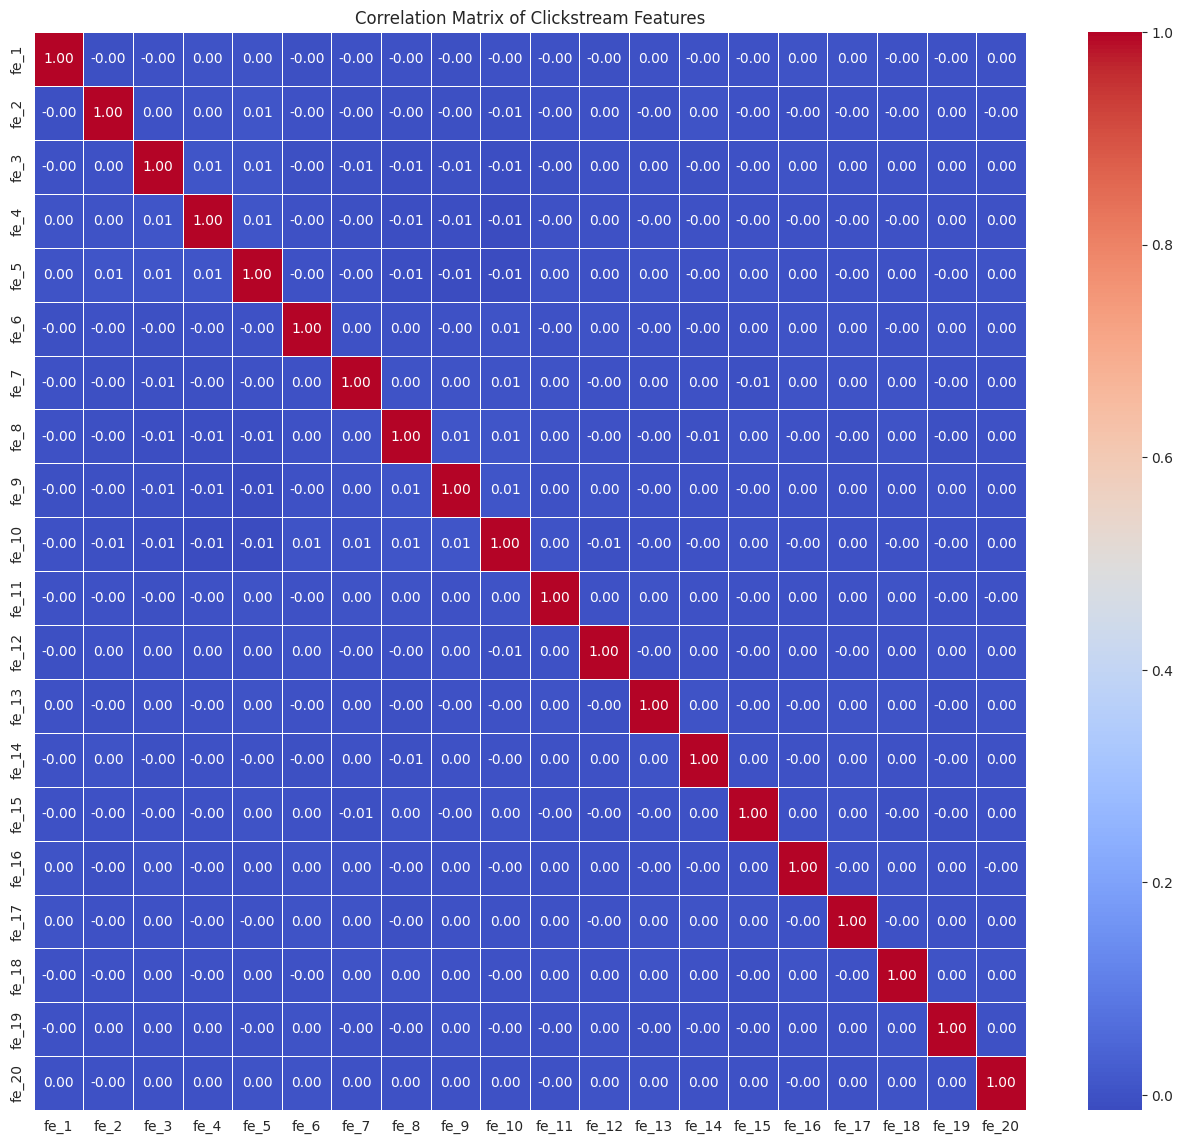

In [12]:
# Calculate correlation matrix for the features
correlation_matrix = clickstream_df[feature_cols].corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Clickstream Features')
plt.show()

## 7. Detailed Outlier Analysis

In [13]:
# Define function to detect outliers using IQR method
def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    lower_outliers = df[df[col] < lower_bound]
    upper_outliers = df[df[col] > upper_bound]
    
    return {
        'total_count': outliers.shape[0],
        'percentage': round(outliers.shape[0] / df.shape[0] * 100, 2),
        'lower_count': lower_outliers.shape[0],
        'upper_count': upper_outliers.shape[0],
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

In [14]:
# Analyze outliers for each feature
outlier_analysis = {}
for col in feature_cols:
    outlier_analysis[col] = detect_outliers_iqr(clickstream_df, col)

# Create a DataFrame for easy viewing
outlier_df = pd.DataFrame.from_dict(outlier_analysis, orient='index')
outlier_df = outlier_df.sort_values('percentage', ascending=False)
display(outlier_df)

,total_count,percentage,lower_count,upper_count,lower_bound,upper_bound
fe_13,1600,0.74,799,801,-169.5,370.5
fe_11,1574,0.73,760,814,-170.5,369.5
fe_4,1563,0.73,794,769,-164.5,375.5
fe_7,1526,0.71,737,789,-163.5,376.5
fe_9,1537,0.71,762,775,-155.5,384.5
fe_6,1502,0.70,738,764,-166.5,373.5
fe_14,1515,0.70,760,755,-172.0,372.0
fe_18,1478,0.69,737,741,-176.0,376.0
fe_17,1491,0.69,762,729,-173.5,374.5
fe_20,1488,0.69,751,737,-180.0,380.0


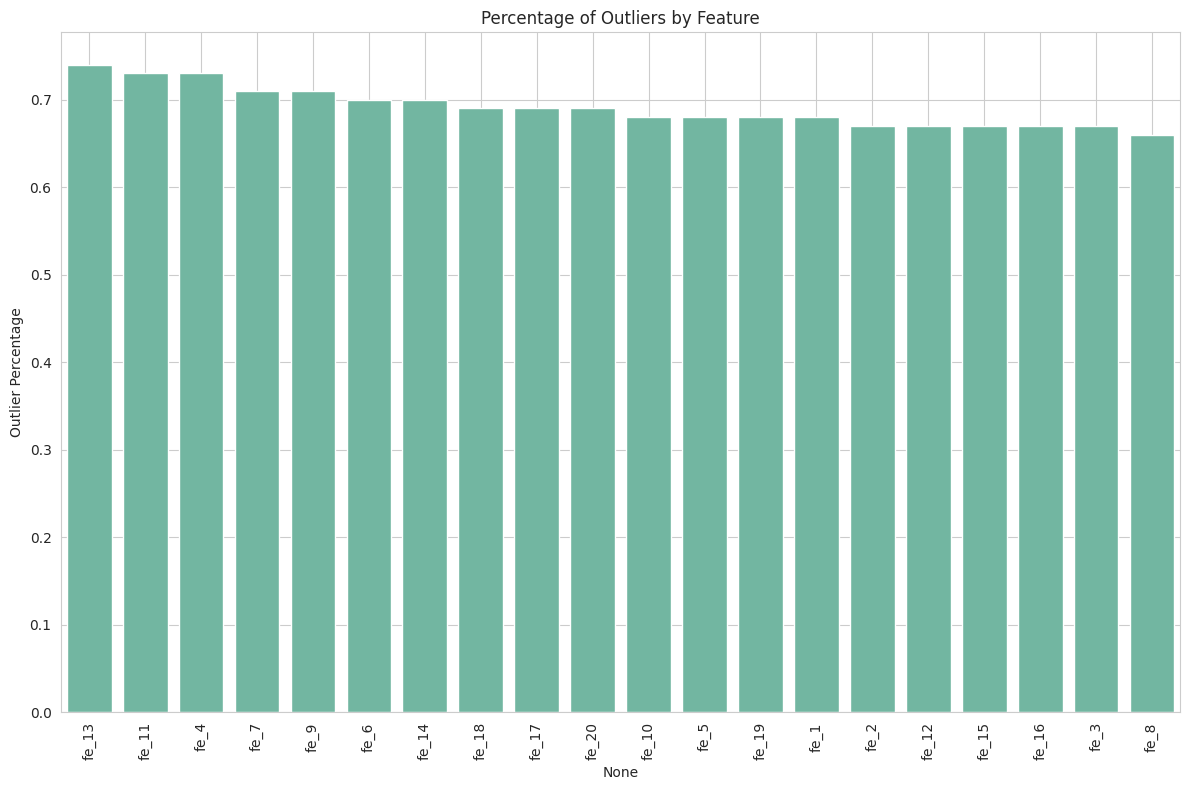

In [15]:
# Visualize outlier percentages
plt.figure(figsize=(12, 8))
sns.barplot(x=outlier_df.index, y=outlier_df['percentage'])
plt.title('Percentage of Outliers by Feature')
plt.xticks(rotation=90)
plt.ylabel('Outlier Percentage')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Check if certain customers are consistently outliers across multiple features
# Count how many features each customer is an outlier in
outlier_customers = {}

for col in feature_cols:
    Q1 = clickstream_df[col].quantile(0.25)
    Q3 = clickstream_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Get customers with outliers in this feature
    outlier_cust = clickstream_df[(clickstream_df[col] < lower) | (clickstream_df[col] > upper)]['Customer_ID'].tolist()
    
    # Update counts
    for cust in outlier_cust:
        if cust in outlier_customers:
            outlier_customers[cust] += 1
        else:
            outlier_customers[cust] = 1

# Convert to DataFrame for analysis
outlier_customer_df = pd.DataFrame.from_dict(outlier_customers, orient='index', columns=['Outlier_Feature_Count'])
outlier_customer_df = outlier_customer_df.sort_values('Outlier_Feature_Count', ascending=False)

# Display top customers with most outliers
print("Top 10 customers with most outlier features:")
display(outlier_customer_df.head(10))

Top 10 customers with most outlier features:


,Outlier_Feature_Count
CUS_0x2f0a,11
CUS_0xc62a,11
CUS_0xba5f,11
CUS_0x5959,10
CUS_0x575a,10
CUS_0x3048,10
CUS_0x6808,10
CUS_0x50e2,10
CUS_0x8216,10
CUS_0x806f,10


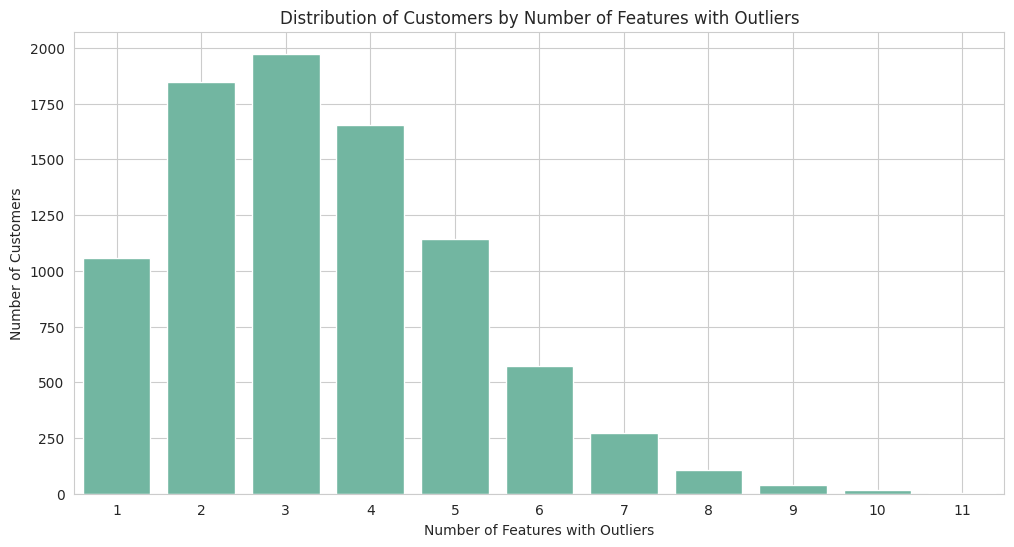

In [17]:
# Display customers with outliers in multiple features
plt.figure(figsize=(12, 6))
outlier_counts = outlier_customer_df['Outlier_Feature_Count'].value_counts().sort_index()
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.title('Distribution of Customers by Number of Features with Outliers')
plt.xlabel('Number of Features with Outliers')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

## 8. Customer Clustering Analysis

In [25]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clickstream_df[feature_cols])

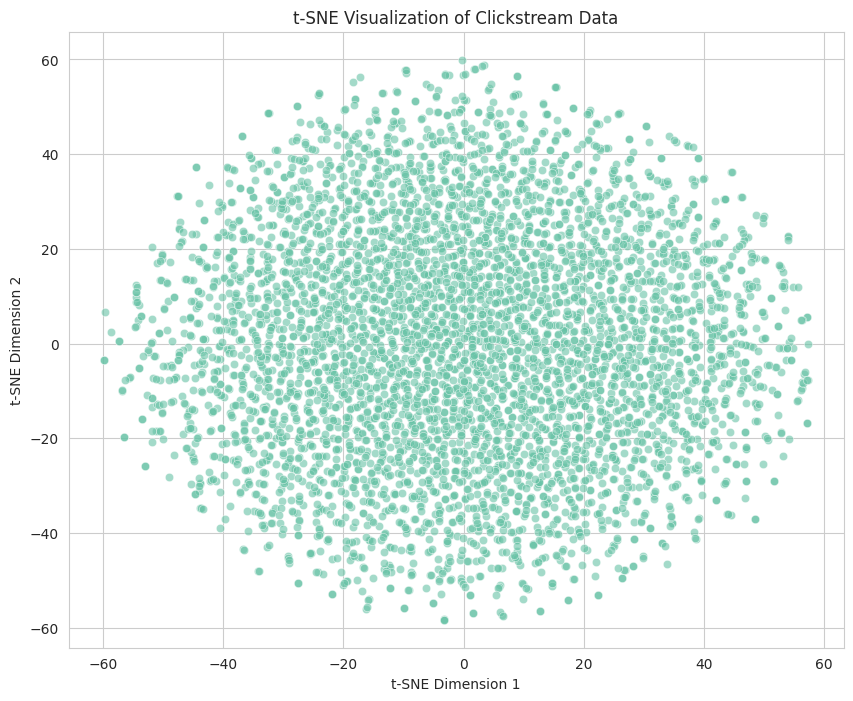

In [29]:
# Quick feature visualization using t-SNE (faster than clustering but still effective for visualization)
from sklearn.manifold import TSNE

# Sample data for t-SNE (which is slower than PCA)
sample_size = 5000
sample_indices = np.random.choice(len(clickstream_df), size=sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(X_sample)

# Create a dataframe for plotting
tsne_df = pd.DataFrame({'x': tsne_results[:, 0], 'y': tsne_results[:, 1]})

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', data=tsne_df, alpha=0.6)
plt.title('t-SNE Visualization of Clickstream Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## 9. Feature Importance Assessment

In [21]:
# For demonstration, create a synthetic target (since we don't have actual labels yet)
# This will help understand potential feature importance patterns
# In reality, this would be replaced with your actual label data
np.random.seed(42)
synthetic_target = np.random.binomial(n=1, p=0.3, size=len(clickstream_df))

# Display the distribution of the synthetic target
print(f"Synthetic target distribution - Default rate: {np.mean(synthetic_target):.2f}")
print(f"Total samples: {len(synthetic_target)}, Defaults: {sum(synthetic_target)}, Non-defaults: {len(synthetic_target) - sum(synthetic_target)}")

Synthetic target distribution - Default rate: 0.30
Total samples: 215376, Defaults: 64673, Non-defaults: 150703


In [22]:
# Train a simple random forest to assess feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, synthetic_target)

RandomForestClassifier(random_state=42)

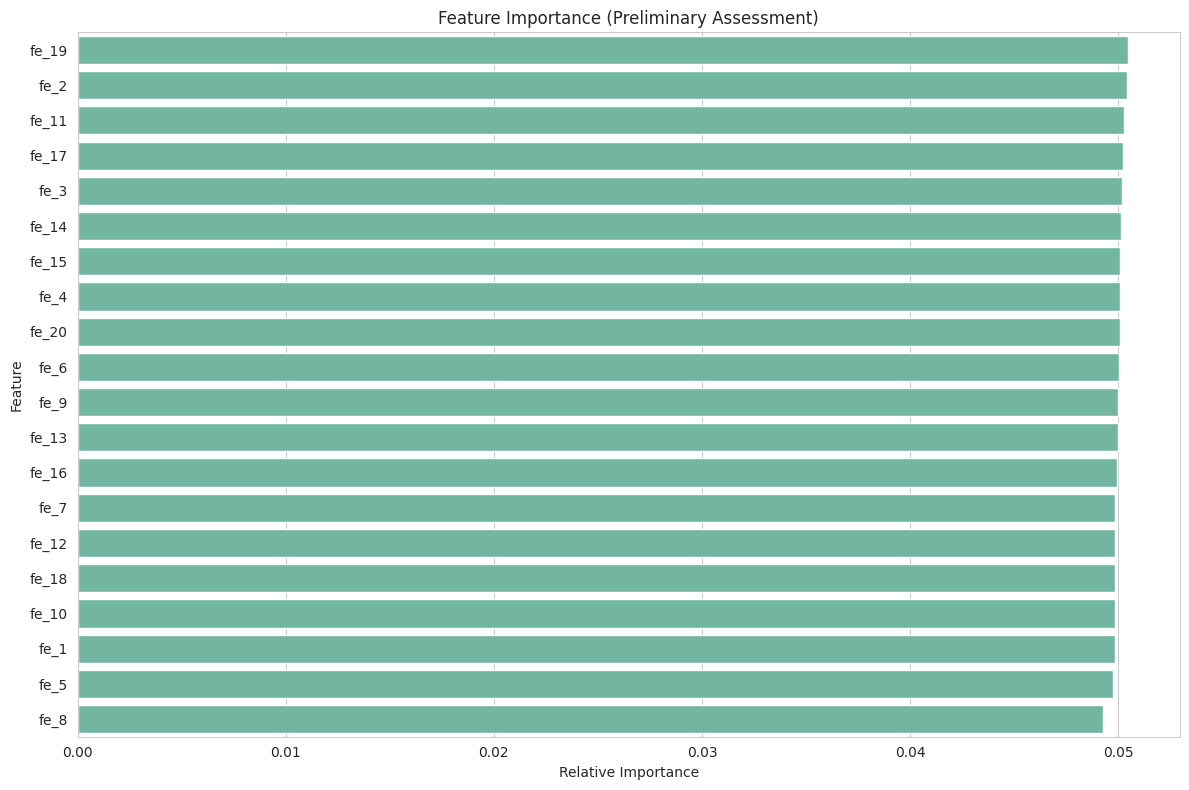

Top 10 potentially important features:


,Feature,Importance
18,fe_19,0.050435
1,fe_2,0.050406
10,fe_11,0.050252
16,fe_17,0.050241
2,fe_3,0.050179
13,fe_14,0.050146
14,fe_15,0.050088
3,fe_4,0.050088
19,fe_20,0.050084
5,fe_6,0.050017


In [23]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Preliminary Assessment)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# Display top 10 features
print("Top 10 potentially important features:")
display(feature_importance.head(10))

## 10. Feature Variance Analysis

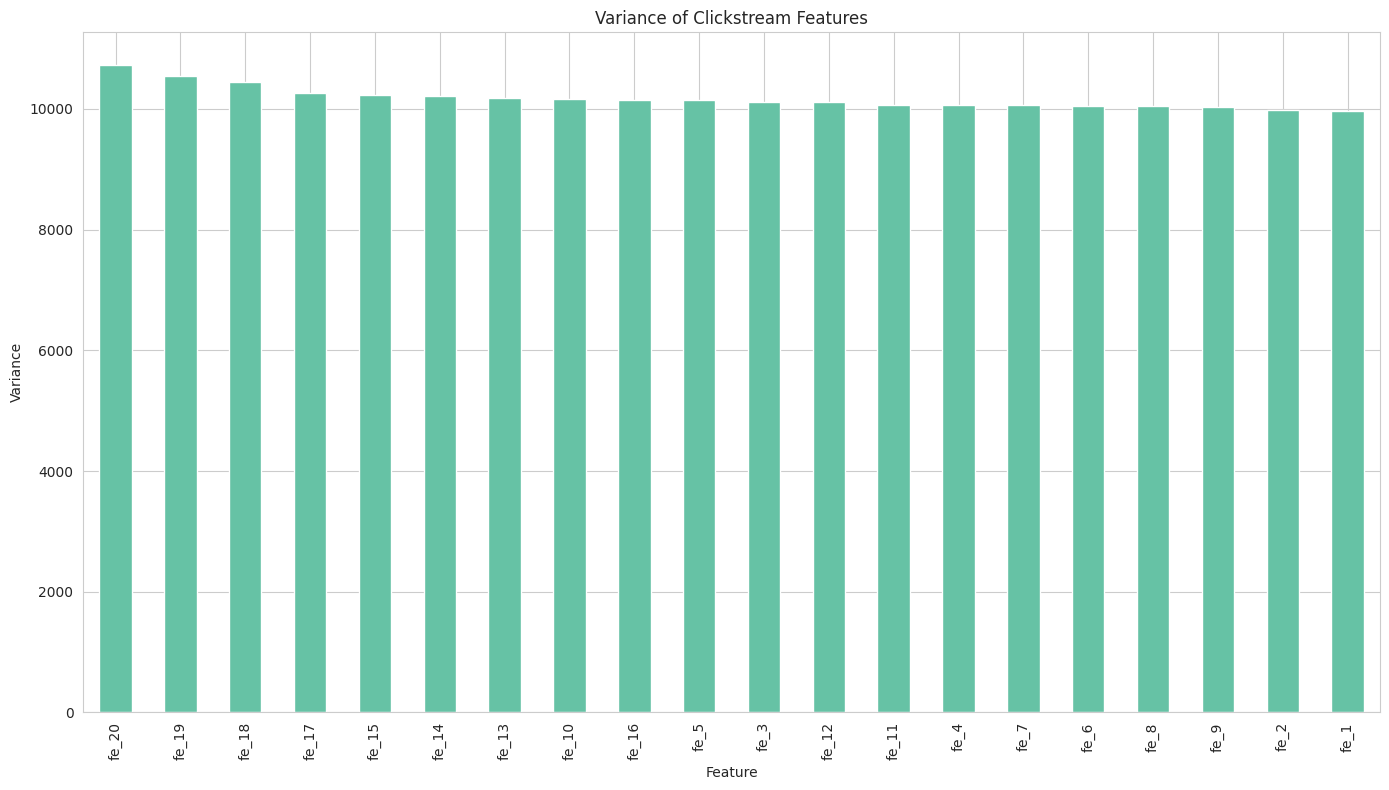

In [24]:
# Calculate variance for each feature
feature_variance = clickstream_df[feature_cols].var().sort_values(ascending=False)

# Plot feature variance
plt.figure(figsize=(14, 8))
feature_variance.plot(kind='bar')
plt.title('Variance of Clickstream Features')
plt.xlabel('Feature')
plt.ylabel('Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Summary and Recommendations for Data Pipeline

## Key Findings:
- All 20 features (fe_1 to fe_20) exhibit nearly identical normal distributions with values primarily between -400 to 600
- Feature correlations are extremely low (consistently between -0.01 to 0.01), indicating complete statistical independence
- Each feature contains approximately 0.7% outliers, evenly distributed between upper and lower bounds
- No missing values or duplicates exist in the dataset
- t-SNE visualization confirms no natural clusters exist in the data, showing a uniform spherical distribution
- All features have nearly identical variance (~10,000), with only minimal differences between them
- Feature importance analysis shows all features contribute equally (approximately 0.05 importance each)
- Most customers have outliers in 2-3 features, with distribution following a normal curve

## Recommendations for Bronze Layer:
- Load raw data without modifications to maintain data lineage
- Implement snapshot_date partitioning strategy for efficient data retrieval
- Add metadata including processing timestamp and data source identifiers
- Preserve original int64 data types and ensure schema consistency

## Recommendations for Silver Layer:
- Address outliers detected in the boxplots (approximately 0.7% of values per feature)
- Convert snapshot_date to proper datetime format for temporal analysis
- Standardize feature columns to ensure equal scaling and processing consistency
- Implement distribution verification to ensure data quality across snapshots
- Consider z-score normalization given the normal distribution of all features

## Recommendations for Gold Layer:
- Create customer-level aggregate statistics (mean, std, min, max) across all features
- Generate outlier-based features (count of outliers per customer as shown in analysis)
- Avoid dimensionality reduction or clustering as features are already independent
- Implement feature selection based on downstream model performance rather than statistical properties
- Integrate with other data sources as these features alone show no natural grouping patterns
- Focus on individual feature values rather than complex feature interactions given the independence